In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import itertools
from PIL import Image

import tensorflow as tf
from keras import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.metrics import categorical_crossentropy

from keras.utils import to_categorical
from keras.preprocessing import image



In [2]:
#Load the train, validation, and test datasets
train_dataset       = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/train_dataset.npy')
validation_dataset  = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/validation_dataset.npy')
test_dataset        = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/test_dataset.npy')

# Load the train, validation, and test labels
train_labels        = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/train_labels.npy')
validation_labels   = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/validation_labels.npy')
test_labels         = np.load('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/Splitted_Dataset/test_labels.npy')

In [3]:
print("The Dataset which is made up of {} Image Arrays has been splitted into:".format(len(train_dataset) + len(validation_dataset) + len(test_dataset)))
print('{} Training Image Arrays'.format(len(train_dataset)))
print('{} Validation Image Arrays'.format(len(validation_dataset)))
print('{} Test Image Arrays'.format(len(test_dataset)))

The Dataset which is made up of 2952 Image Arrays has been splitted into:
2361 Training Image Arrays
295 Validation Image Arrays
296 Test Image Arrays


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator with desired augmentation settings
data_augmentation = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values to range [0, 1]
    rotation_range=20,        # Rotate images randomly within the range of 20 degrees
    width_shift_range=0.2,    # Shift the width of the image randomly by a fraction of 0.2
    height_shift_range=0.2,   # Shift the height of the image randomly by a fraction of 0.2
    shear_range=0.2,          # Apply shear transformation randomly within the range of 0.2
    zoom_range=0.2,           # Apply random zooming to the images within the range of 0.2
    horizontal_flip=True,     # Perform random horizontal flipping of the images
    fill_mode='nearest',      # Use the nearest pixel to fill any newly created pixels during transformations
)


In [5]:
from keras.applications import MobileNet

def make_mobilenet_model(image_size, num_classes):
    input_shape = image_size + (3,)

    base_model = MobileNet(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(units=num_classes, activation= 'softmax')
    ])

    return model

In [6]:
# Define a model using the make_model function
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

# Preview the Model Summary
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
Total params: 3231939 (12.33 MB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [7]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate=base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=8, verbose=1, min_lr=2e-6)

mobilenet_model.compile(optimizer=optimizer, 
                        loss=loss, 
                        metrics=metrics)

In [8]:
# Generate augmented images on-the-fly using the ImageDataGenerator
train_generator = data_augmentation.flow(
    x=train_dataset,
    y=train_labels,
    batch_size=batch_size,
    shuffle=True
)

In [9]:
mobilenet_history_freeze = mobilenet_model.fit(train_dataset,
                                               train_labels,
                                               batch_size=batch_size,
                                               epochs=initial_epochs,
                                               validation_data=(validation_dataset, validation_labels),
                                               callbacks=[callback, reduce_lr],
                                               shuffle=True
)

Epoch 1/50
37/37 [==============================] - 150s 3s/step - loss: 0.7977 - accuracy: 0.6442 - val_loss: 0.4166 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 2/50
37/37 [==============================] - 107s 3s/step - loss: 0.4166 - accuracy: 0.8378 - val_loss: 0.3343 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 3/50
37/37 [==============================] - 106s 3s/step - loss: 0.3475 - accuracy: 0.8611 - val_loss: 0.3043 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 4/50
37/37 [==============================] - 105s 3s/step - loss: 0.3101 - accuracy: 0.8738 - val_loss: 0.2910 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 5/50
37/37 [==============================] - 97s 3s/step - loss: 0.2895 - accuracy: 0.8878 - val_loss: 0.2678 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 6/50
37/37 [==============================] - 97s 3s/step - loss: 0.2672 - accuracy: 0.8903 - val_loss: 0.2605 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 7/50
37/37 [==============================] - 97s 3s/step - loss: 0.2637

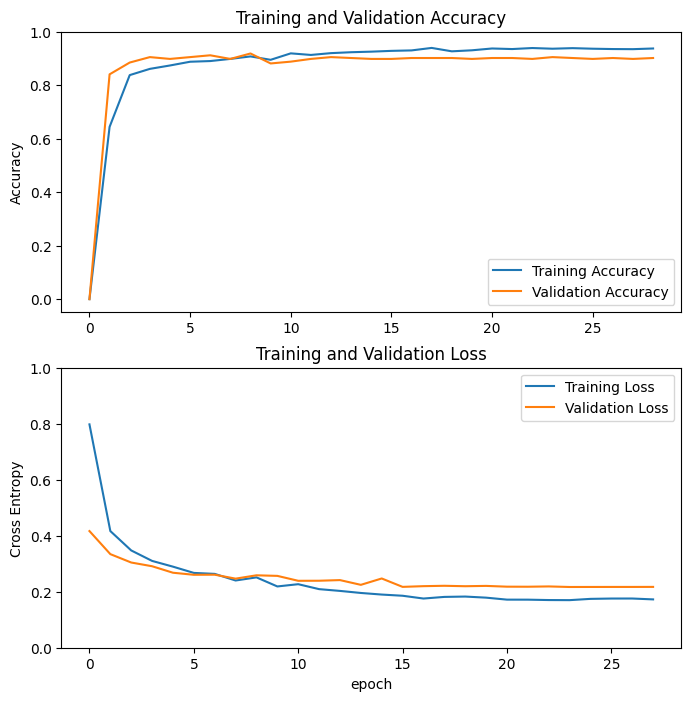

In [10]:
acc = [0.] + mobilenet_history_freeze.history['accuracy']
val_acc = [0.] + mobilenet_history_freeze.history['val_accuracy']

loss = mobilenet_history_freeze.history['loss']
val_loss = mobilenet_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
mobilenet_model.save('D:/Latihan_Python/Notebooks/Tugas Akhir/801010  testing/mobilenetV1_CXR_lassification_801010.h5')

c:\Users\K I K I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
